<a href="https://colab.research.google.com/github/alexk2206/Data_Driven_Fantasy_Football/blob/dev/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
MIP_sim_2024_dfs = []
for run in range(1, 6):
    url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/simulations/MIP/simulation_results_MIP_ALL_2024_run{run}.json"
    df = pd.read_json(url)
    df["Run"] = run
    MIP_sim_2024_dfs.append(df)

MIP_sim_2024 = pd.concat(MIP_sim_2024_dfs, ignore_index=True)

In [ ]:
MIP_sim_2023_dfs = []
for run in range(1, 4):
    url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/dev/simulations/MIP/simulation_results_MIP_ALL_2023_run{run}.json"
    df = pd.read_json(url)
    df["Run"] = run
    MIP_sim_2023_dfs.append(df)

MIP_sim_2023 = pd.concat(MIP_sim_2023_dfs, ignore_index=True)

In [ ]:
ADP_sim_2024_dfs = []
for run in range(1, 2):
    url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/simulations/ADP/simulation_results_ADP_ALL_2024_run{run}.json"
    df = pd.read_json(url)
    df["Run"] = run
    ADP_sim_2024_dfs.append(df)

ADP_sim_2024 = (
    pd.concat(ADP_sim_2024_dfs, ignore_index=True)
)
print(len(ADP_sim_2024))

500


In [ ]:
ADP_sim_2023_dfs = []
for run in range(1, 11):
    url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/dev/simulations/ADP/simulation_results_ADP_{run}_2023.json"
    df = pd.read_json(url)
    df["Run"] = run
    ADP_sim_2023_dfs.append(df)

ADP_sim_2023 = (
    pd.concat(ADP_sim_2023_dfs, ignore_index=True)
)
print(len(ADP_sim_2023))

500


In [ ]:
import pandas as pd
import re
from collections import Counter

# Funktion zur Extraktion der Spielernamen (ohne Pick-Nummer)
def extract_players(pick_string):
    if isinstance(pick_string, float) and pd.isna(pick_string):
        return []
    if isinstance(pick_string, list):
        entries = pick_string
    else:
        entries = str(pick_string).split(",")
    return [re.sub(r"\s*\(Pick \d+\)", "", p.strip()) for p in entries]

# Beispiel: MIP_sim_2023 muss vorher definiert sein
all_players = MIP_sim_2023['DM-Picks'].dropna().apply(extract_players)
flat_list = [player for sublist in all_players for player in sublist]
player_counts = Counter(flat_list)

# Ergebnis als DataFrame
player_freq_df = (
    pd.DataFrame(player_counts.items(), columns=["Player", "Count"])
    .sort_values(by="Count", ascending=False)
    .reset_index(drop=True)
)

print(player_freq_df.head(20))  # Top 20


                Player  Count
0           Skyy Moore    273
1      Zach Charbonnet    270
2         Dak Prescott    255
3        Gabriel Davis    231
4       Kadarius Toney    225
5           Nick Chubb    218
6      Jerick McKinnon    209
7        Damien Harris    207
8          Zay Flowers    207
9         Jahmyr Gibbs    182
10         Chris Olave    172
11              Browns    166
12               49ers    151
13       Calvin Ridley    120
14       Dameon Pierce    116
15       Justin Tucker    105
16  Kenneth Walker III    104
17     Mitchell Wilcox     97
18       Luke Musgrave     92
19         Josh Jacobs     91


In [ ]:
print(ADP_sim_2024.columns)
print(ADP_sim_2023.value_counts("Winner"))

# Spaltennamen bereinigen, falls nötig
ADP_sim_2023.columns = ADP_sim_2023.columns.str.strip()

# 1. Siege pro Team
wins_per_team = ADP_sim_2023.groupby("Winner")["Simulation"].count().rename("Wins")

# 2. Durchschnittliche Punkte pro Team
points_mean = ADP_sim_2023.groupby("Winner")[["Points Reg Season", "Points Full Season"]].mean()

# 3. Zusammenführen in ein gemeinsames DataFrame
summary_df = pd.concat([wins_per_team, points_mean], axis=1).sort_values("Wins", ascending=False)

# 4. Korrelation berechnen
correlation = summary_df.corr()

# Ausgabe
summary_df



Index(['Simulation', 'Winner', 'Roster', 'Points Reg Season',
       'Points Full Season', 'Run', 'Draftslot'],
      dtype='object')
Winner
Team 5     66
Team 1     63
Team 6     55
Team 2     49
Team 12    45
Team 11    41
Team 8     35
Team 4     32
Team 3     32
Team 10    31
Team 7     31
Team 9     20
Name: count, dtype: int64


,Wins,Points Reg Season,Points Full Season
Winner,,,
Team 5,66,1445.923636,1751.775455
Team 1,63,1450.074286,1781.548254
Team 6,55,1446.711636,1755.879273
Team 2,49,1406.920000,1729.182857
Team 12,45,1403.859111,1726.788889
Team 11,41,1358.752195,1680.137561
Team 8,35,1429.106286,1745.068000
Team 4,32,1406.898125,1716.130625
Team 3,32,1383.031875,1695.681875


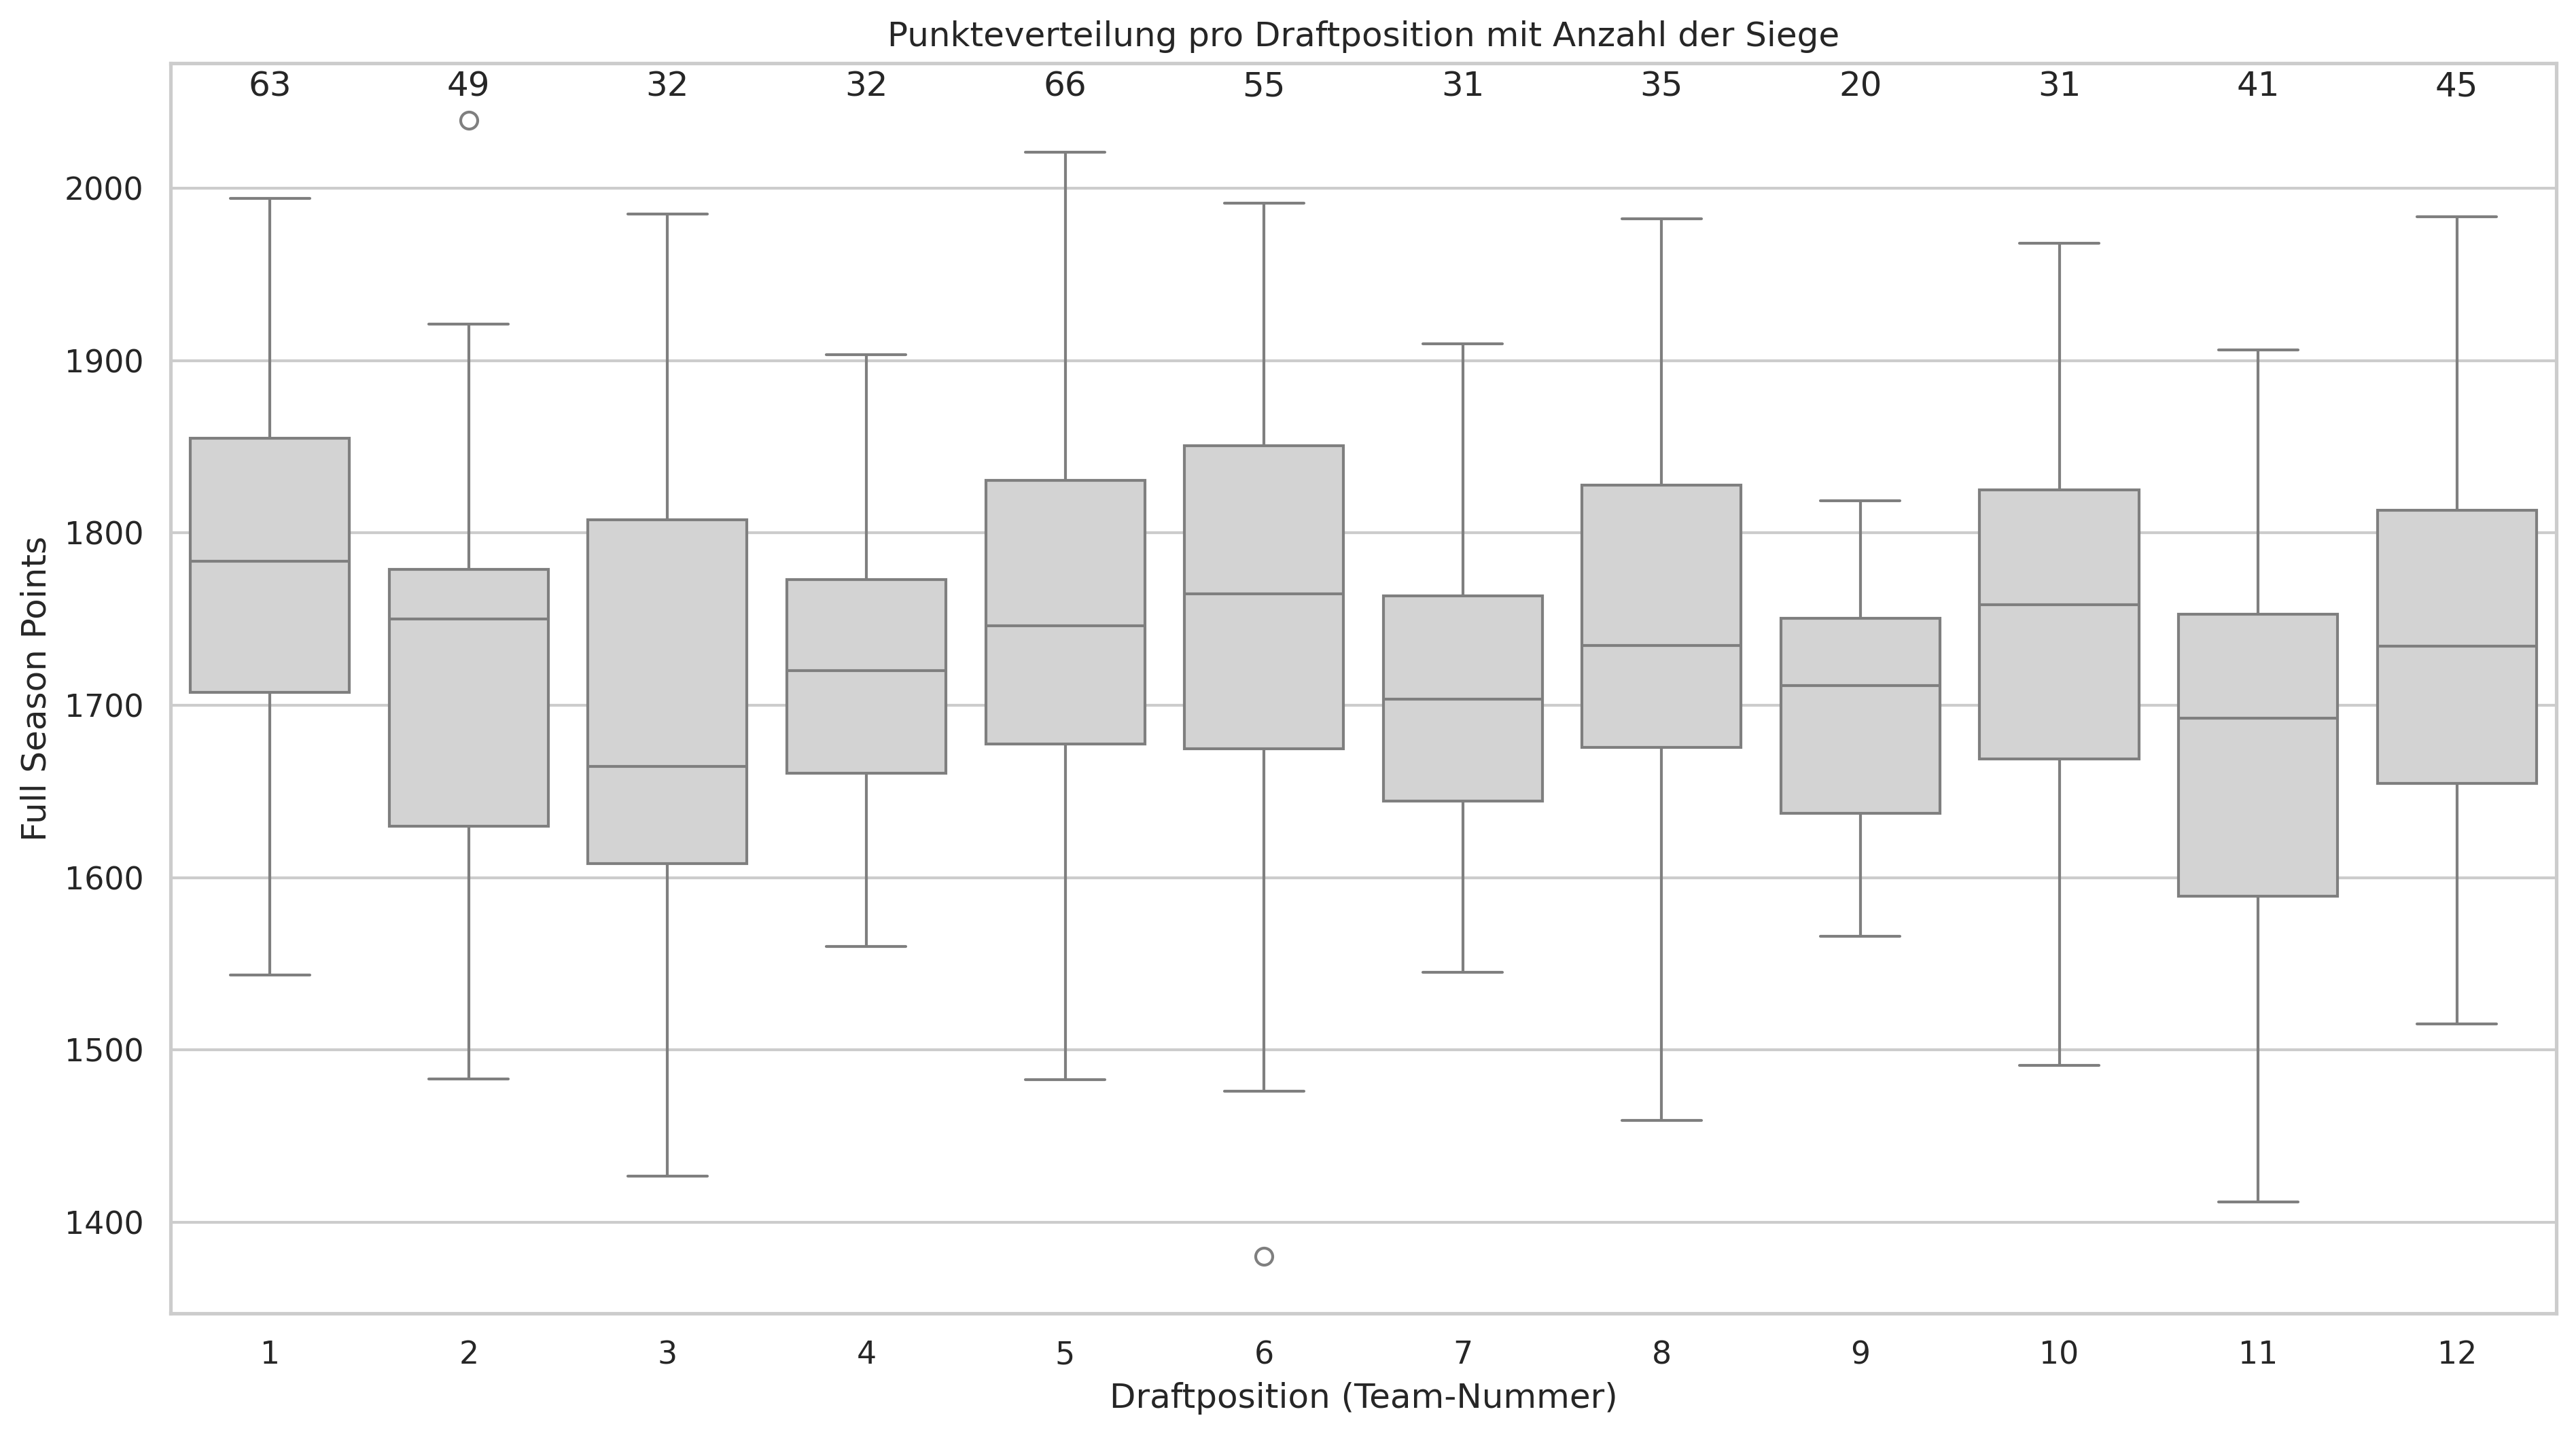

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: Seaborn-Theme setzen
# sns.set_theme(style="whitegrid", palette="bright")

# Spalten bereinigen
ADP_sim_2023.columns = ADP_sim_2023.columns.str.strip()

# Draftslot berechnen (aus Teamnummer)
ADP_sim_2023["Draftslot"] = ADP_sim_2023["Winner"].str.extract(r"(\d+)").astype(int)

# Siege pro Draftslot zählen
win_counts = ADP_sim_2023["Draftslot"].value_counts().sort_index()

# 4K-Figure vorbereiten (300 dpi, 3840x2160)
fig, ax = plt.subplots(figsize=(3840 / 300, 2160 / 300), dpi=300)

# Boxplot
sns.boxplot(data=ADP_sim_2023, x="Draftslot", y="Points Full Season", color='lightgray', ax=ax)

# Siege über den Boxplots einblenden
max_y = ADP_sim_2023["Points Full Season"].max()
for i, slot in enumerate(sorted(ADP_sim_2023["Draftslot"].unique())):
    wins = win_counts.get(slot, 0)
    ax.text(i, max_y + 10, f'{wins}', ha='center', va='bottom', fontsize=12)

# Achsen, Titel, Layout
ax.set_title("Punkteverteilung pro Draftposition mit Anzahl der Siege")
ax.set_xlabel("Draftposition (Team-Nummer)")
ax.set_ylabel("Full Season Points")
ax.grid(True, axis='y')
fig.tight_layout()

# Speichern (für 4K Export)
fig.savefig("ADP_sim_2023_boxplot.png")  # Speicherpfad anpassbar


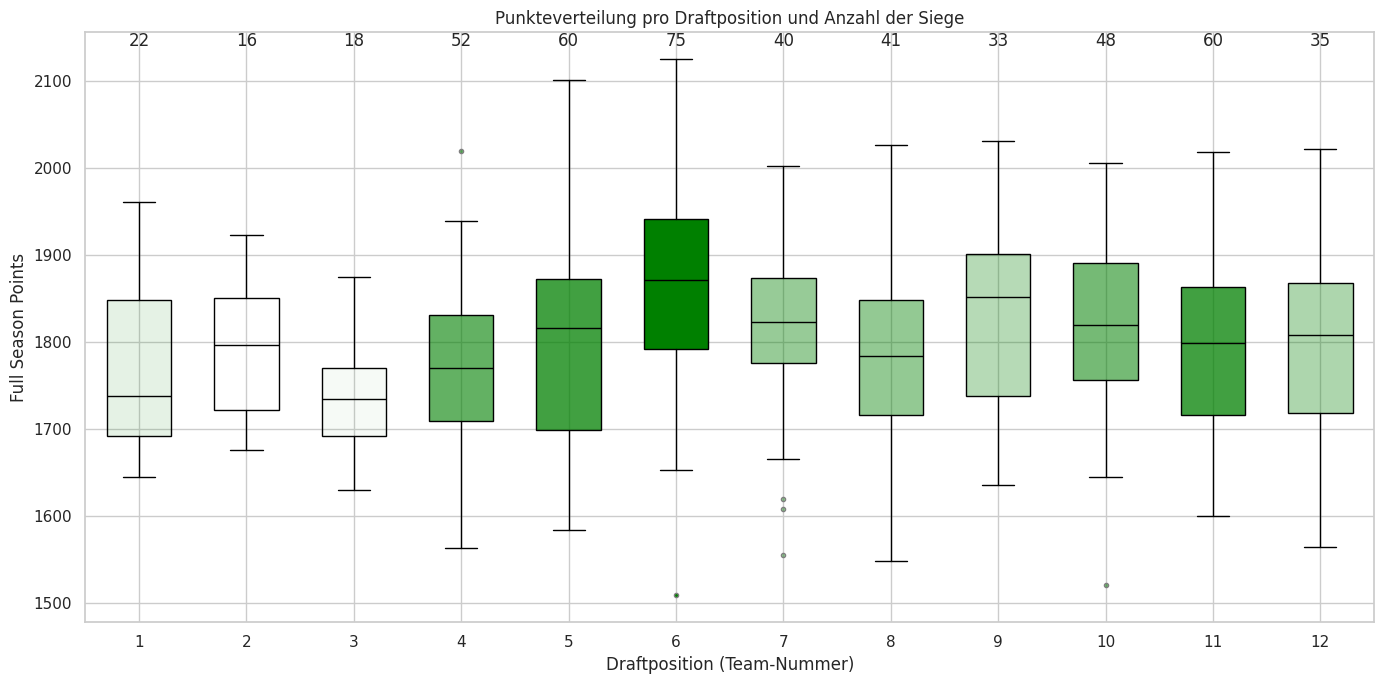

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import to_rgba

# Draftslot berechnen und Siege zählen
ADP_sim_2024["Draftslot"] = ADP_sim_2024["Winner"].str.extract(r"(\d+)").astype(int)
win_counts = ADP_sim_2024["Draftslot"].value_counts().sort_index()

# Transparenz normalisieren (0 = wenig Siege → 1 = viele Siege)
min_wins, max_wins = win_counts.min(), win_counts.max()
norm = (win_counts - min_wins) / (max_wins - min_wins + 1e-8)

# Mapping: Draftslot → transparente grüne Farbe
def transparent_green(alpha):
    return to_rgba("green", alpha)

slot_colors = {slot: transparent_green(alpha) for slot, alpha in norm.items()}

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(14, 7))
slots = sorted(ADP_sim_2024["Draftslot"].unique())

# Einzelne Boxplots mit Farbfüllung
for i, slot in enumerate(slots):
    y = ADP_sim_2024.loc[ADP_sim_2024["Draftslot"] == slot, "Points Full Season"]
    ax.boxplot(y, positions=[i], widths=0.6,
               patch_artist=True,
               boxprops=dict(facecolor=slot_colors[slot], color='black'),
               medianprops=dict(color='black'),
               whiskerprops=dict(color='black'),
               capprops=dict(color='black'),
               flierprops=dict(marker='o', markersize=3, linestyle='none',
                               markerfacecolor=slot_colors[slot], markeredgecolor='gray'))

    # Siege als Text oberhalb
    wins = win_counts.get(slot, 0)
    ax.text(i, max_y + 10, f"{wins}", ha='center', va='bottom', fontsize=12)

# Achsen, Titel, Layout
ax.set_xticks(range(len(slots)))
ax.set_xticklabels(slots)
ax.set_xlabel("Draftposition (Team-Nummer)")
ax.set_ylabel("Full Season Points")
ax.set_title("Punkteverteilung pro Draftposition und Anzahl der Siege")
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()
